In [ ]:
from pyspark.sql import SparkSession

In [ ]:
import pyspark.sql.functions as F

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.appName('MMDS').getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = spark.read.csv('/content/drive/MyDrive/MMDS/Midterm/baskets.csv', header=True, inferSchema=True)
# Dùng inferSchema tự động suy luận kiểu dữ liệu
# Dữ liệu không quá lớn và phức tạp, dữ liệu ở các cột có cấu trúc đơn giản
# Chọn inferSchema sẽ tiết kiệm thời gian cấu hình và hoạt động tốt ở dữ liệu này

In [ ]:
df.printSchema()

root
 |-- Member_number: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [ ]:
df.show(5)

+-------------+----------+----------------+----+-----+---+-----------+
|Member_number|      Date| itemDescription|year|month|day|day_of_week|
+-------------+----------+----------------+----+-----+---+-----------+
|         1249|01/01/2014|    citrus fruit|2014|    1|  1|          2|
|         1249|01/01/2014|          coffee|2014|    1|  1|          2|
|         1381|01/01/2014|            curd|2014|    1|  1|          2|
|         1381|01/01/2014|            soda|2014|    1|  1|          2|
|         1440|01/01/2014|other vegetables|2014|    1|  1|          2|
+-------------+----------+----------------+----+-----+---+-----------+
only showing top 5 rows



In [ ]:
class BasketAnalysis:
    def __init__(self, file_path):
        # Khởi tạo Spark session và đọc file CSV
        self.spark = SparkSession.builder.appName('BasketAnalysis').getOrCreate()
        self.df = self.spark.read.csv(file_path, header=True, inferSchema=True)

    def plot_bar(self, data, x_col, y_col, title, x_label, y_label, output_csv=None, output_img=None, invert_y=False):
        """
        Vẽ biểu đồ cột và lưu kết quả.
        :param data: DataFrame chứa dữ liệu để vẽ.
        :param x_col: Tên cột trục X.
        :param y_col: Tên cột trục Y.
        :param title: Tiêu đề biểu đồ.
        :param x_label: Nhãn trục X.
        :param y_label: Nhãn trục Y.
        :param output_csv: Đường dẫn lưu file CSV.
        :param output_img: Đường dẫn lưu ảnh.
        :param invert_y: Đảo ngược trục Y nếu True.
        """
        plt.figure(figsize=(12, 8))
        if invert_y:
            plt.barh(data[x_col].astype(str), data[y_col], color='skyblue')
            plt.gca().invert_yaxis()
        else:
            plt.bar(data[x_col].astype(str), data[y_col], color='skyblue')

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.tight_layout()

        if output_img:
            plt.savefig(output_img)
        if output_csv:
            data.to_csv(output_csv, index=False)
        plt.show()
    # F1
    def analyze_top_items(self, num_items=100, output_csv=None, output_img=None):
        """
        Thực hiện phân tích F1: Thống kê số lần mỗi món hàng được mua và vẽ biểu đồ.
        """
        # Lọc danh sách món hàng và đếm số lần mỗi món hàng được mua
        items_count = df.groupBy("itemDescription") \
                .agg(F.count("*").alias("count")) \
                .sort("count", ascending=False)

        top_items = items_count.limit(num_items).toPandas()
        self.plot_bar(
            top_items, "itemDescription", "count",
            "Top 100 Items Purchased", "Purchase Count", "Item Description",
            output_csv, output_img, invert_y=True
        )
    # F2
    def analyze_user_baskets(self, num_users=100, output_csv=None, output_img=None):
        """
        Thực hiện phân tích F2: Thống kê số lượng giỏ hàng của từng người dùng.
        """
        # Nhóm dữ liệu theo Member_number và Date, mỗi nhóm ứng với 1 giỏ hàng(các itemDescription) mà khách hàng mua trong 1 ngày
        # user_basket_count = self.df.groupBy("Member_number", "Date") \
        #                            .agg(F.collect_list("itemDescription").alias("Grouped_items")) \
        #                            .groupBy("Member_number") \  # Đếm số lượng giỏ hàng mà mỗi người dùng đã mua theo ngày
        #                            .agg(F.count("Date").alias("basket_count")) \
        #                            .sort("basket_count", ascending=False)
        # Nhóm dữ liệu theo Member_number và Date, mỗi nhóm ứng với 1 giỏ hàng(các itemDescription) mà khách hàng mua trong 1 ngày, # Đếm số lượng giỏ hàng mà mỗi người dùng đã mua theo ngày
        user_basket_count = self.df.groupBy("Member_number", "Date") \
                                   .agg(F.collect_list("itemDescription").alias("Grouped_items")) \
                                   .groupBy("Member_number") \
                                   .agg(F.count("Date").alias("basket_count")) \
                                   .sort("basket_count", ascending=False)
        top_users = user_basket_count.limit(num_users).toPandas()
        self.plot_bar(
            top_users, "Member_number", "basket_count",
            "Top 100 Users with Most Baskets", "Basket Count", "User ID",
            output_csv, output_img, invert_y=True
        )
    # F3
    def analyze_item_monthly_sales(self, item_name, output_csv=None, output_img=None):
        """
        Thực hiện phân tích F3: Thống kê số lần mua món hàng cụ thể theo tháng.
        """
        # Lọc theo giỏ hàng chứa món hàng
        filtered_df = self.df.filter(F.col("itemDescription").like(item_name))
        # Nhóm dữ liệu theo tháng và tính số lần món hàng được mua
        monthly_sales = filtered_df.groupBy("month") \
                                   .agg(F.count("*").alias(f"# sold {item_name} per month")) \
                                   .sort("month")
        monthly_sales_pd = monthly_sales.toPandas()
        self.plot_bar(
            monthly_sales_pd, "month", f"# sold {item_name} per month",
            f'Monthly Sales of {item_name}', 'Month', f'Sales Count of {item_name}',
            output_csv, output_img
        )
    # F4
    def analyze_customer_monthly_purchases(self, customer_id, output_csv=None, output_img=None):
        """
        Thực hiện phân tích F4: Thống kê số lần mua hàng của khách hàng theo từng tháng.
        """
        # Lọc dữ liệu khách hàng theo id
        filtered_df = self.df.filter(F.col("Member_number") == customer_id)
        # Nhóm dữ liệu theo tháng và tính số lần mua hàng cho từng tháng
        monthly_purchases = filtered_df.groupBy("month") \
                                       .agg(F.count("*").alias(f"# purchases by customer {customer_id}")) \
                                       .sort("month")
        monthly_purchases_pd = monthly_purchases.toPandas()
        self.plot_bar(
            monthly_purchases_pd, "month", f"# purchases by customer {customer_id}",
            f'Monthly Purchases of Customer {customer_id}', 'Month', f'Purchase Count by Customer {customer_id}',
            output_csv, output_img
        )




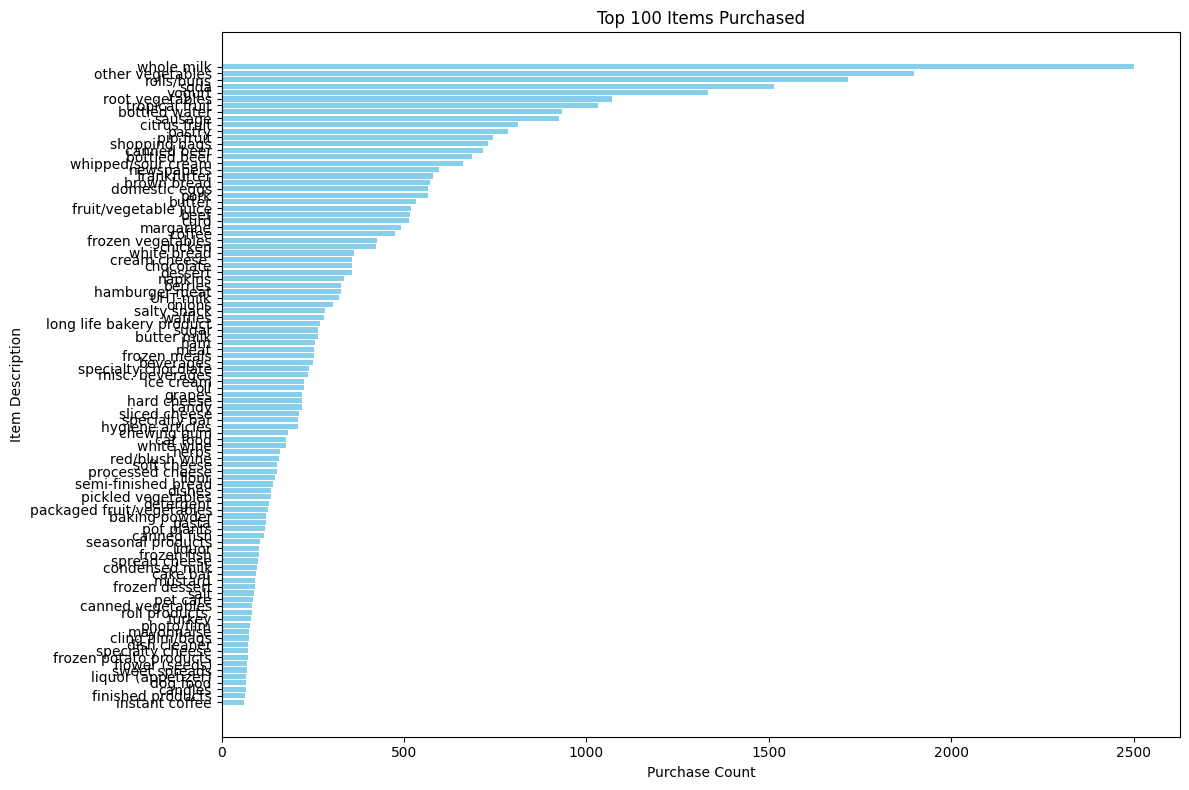

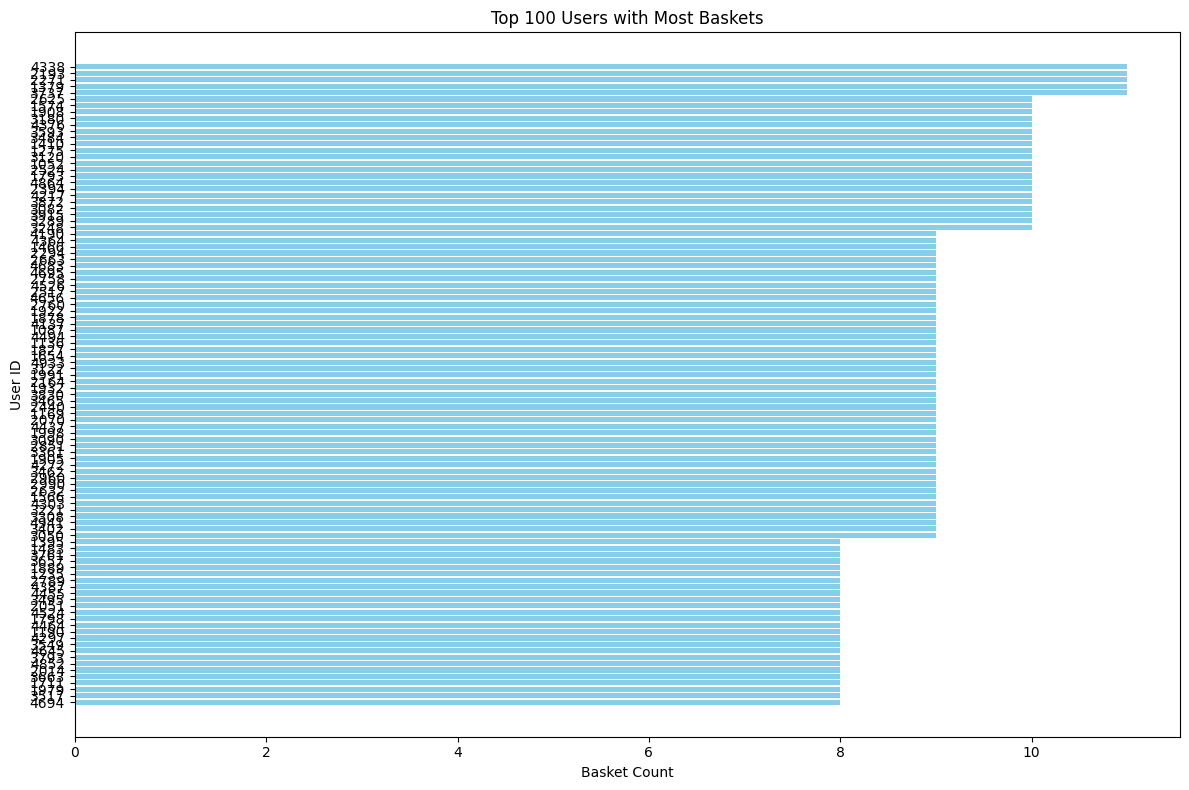

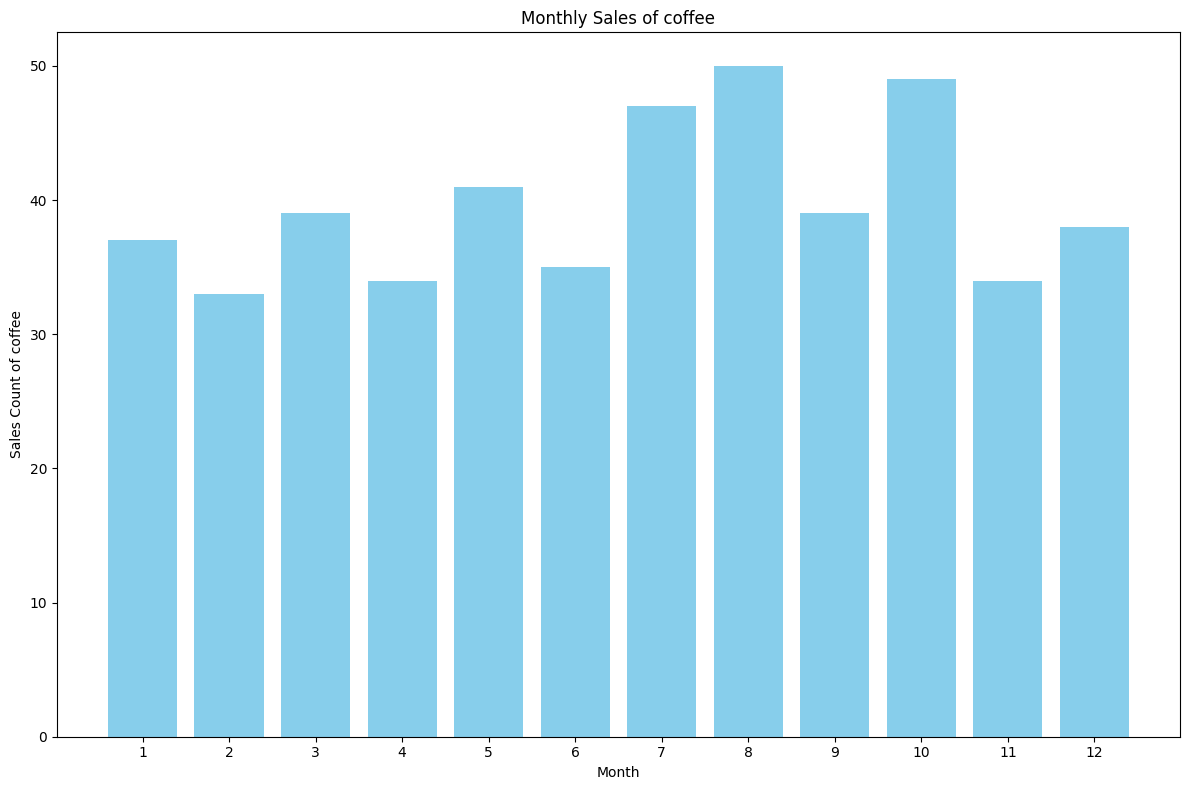

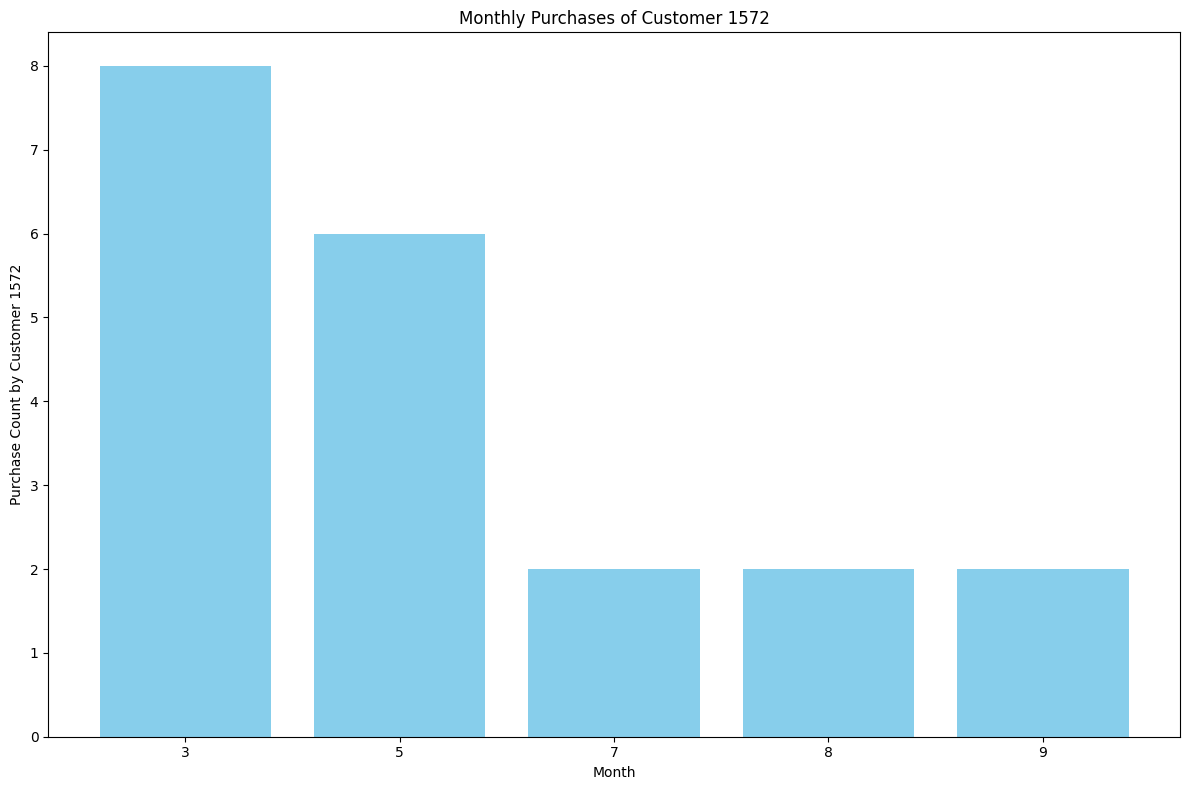

In [ ]:
# Cách sử dụng
if __name__ == "__main__":
    # Khởi tạo class
    file_path = '/content/drive/MyDrive/MMDS/Midterm/baskets.csv'
    analysis = BasketAnalysis(file_path)

    # Thực hiện F1: Top 100 món hàng
    analysis.analyze_top_items(
        num_items=100,
        output_csv="/content/drive/MyDrive/MMDS/Midterm/output1/f1/top_100_items.csv",
        output_img="/content/drive/MyDrive/MMDS/Midterm/output1/f1/top_100_items.png"
    )

    # Thực hiện F2: Top 100 người dùng mua nhiều giỏ hàng nhất
    analysis.analyze_user_baskets(
        num_users=100,
        output_csv="/content/drive/MyDrive/MMDS/Midterm/output1/f2/top_100_users.csv",
        output_img="/content/drive/MyDrive/MMDS/Midterm/output1/f2/top_100_users.png"
    )

    # Thực hiện F3: Thống kê số lần mua coffee theo tháng
    analysis.analyze_item_monthly_sales(
        item_name="coffee",
        output_csv="/content/drive/MyDrive/MMDS/Midterm/output1/f3/monthly_sales.csv",
        output_img="/content/drive/MyDrive/MMDS/Midterm/output1/f3/monthly_sales.png"
    )

    # Thực hiện F4: Thống kê số lần mua của khách hàng theo từng tháng
    analysis.analyze_customer_monthly_purchases(
        customer_id="1572",
        output_csv="/content/drive/MyDrive/MMDS/Midterm/output1/f4/monthly_purchases.csv",
        output_img="/content/drive/MyDrive/MMDS/Midterm/output1/f4/monthly_purchases.png"
    )